In [1]:
import chess 
import chess.pgn
import glob
import pandas as pd
import os 
import re 

# list each folder of folder "games"
# get all folders
folders = glob.glob("games_gpt4o/*")

# sort folders by date
folders.sort(key=os.path.getmtime)

df = pd.DataFrame(columns=["white", "black", "white_elo", "black_elo", "result", "nmoves", "nstarting_move", "pgn_base", "temperature", "random_engine", "has_illegal", "illegal_move", "folder_name"])

for folder in folders:

    # for each folder:
    # read PGN file "game.pgn"

    # check that "game.pgn" exists
    if not os.path.exists(folder + "/game.pgn"):
        print("No game.pgn in " + folder) # TODO
        continue

    with open(folder + "/game.pgn") as pgn:
        game = chess.pgn.read_game(pgn)

    # read metainformation.txt
    # get the GPT model and the engine (SF or random)
    nmove_value = None
    with open(folder + "/metainformation.txt") as f:
        lines = f.readlines()

    # Iterate over each line in the file
    for line in lines:
        # Check if the line contains the string 'nmove:'
        if 'nmove:' in line:
            # Split the line at 'nmove:' and take the second part
            # Then strip leading and trailing whitespaces and convert to integer
            nmove_value = int(line.split('nmove:')[1].strip())
            # Print the extracted value
            break
    
    if nmove_value is None:
        nmove_value = 1 # default value
    
    
   

    # number of moves
    game_length = len(list(game.mainline_moves()))




    # for each PGN:
    # get the GPT model and the engine (SF or random)
    white = game.headers["White"]
    black = game.headers["Black"]


    # get the Elo of the engine (if any)

    # get the Elo of the player (if any)
    white_elo = game.headers["WhiteElo"]
    black_elo = game.headers["BlackElo"]

    # get the result (or infer based on checkmates) # special case: no mate, or unifinished game due to wrong move
    result = game.headers["Result"]

    has_illegal = False
    illegal_move = ''
    # check that UnknownSAN key is in game
    # if not, continue
    if 'UnknownSAN' in game.headers:
        has_illegal = True
        illegal_move = game.headers["UnknownSAN"]
        print("warning: UnknownSAN in game")
        # continue

    with open(folder + "/metainformation.txt") as file:
        content = file.read()

    # find the content between 'temperature:' and ends of line
    match_random = re.search(r'random_engine:([\s\S]+?)(\n)', content, re.MULTILINE)
    random_engine = None
    if match_random:
        random_engine = match_random.group(1).strip()
        if 'True' in random_engine:
            random_engine = True
        elif 'False' in random_engine:
            random_engine = False
        else:   
            print("random engine value unclear/unknwon")
                
    else:
        random_engine = False
        # print('No random engine found') # default value: False (note: should not happen)

    with open(folder + "/metainformation.txt") as file:
        content = file.read()

    # find the content between 'temperature:' and ends of line
    match_temperature = re.search(r'temperature:([\s\S]+?)(\n)', content, re.MULTILINE)
    temperature = None
    if match_temperature:
        temperature = match_temperature.group(1).strip()
        # print(extracted_content)
    else:
        temperature = 0.0
        # print('No temperature found') # default value: 0

    with open(folder + "/metainformation.txt") as file:
        content = file.read()

    # Find the content between 'base_pgn:' and another term at the start of a new line followed by ':'
    match = re.search(r'base_pgn:([\s\S]+?)(^\w+:)', content, re.MULTILINE)
    pgn_base = ''
    if match:
        # Extract and clean up the matched content
        pgn_base = match.group(1).strip()
        # print(extracted_content)
    else:
        print('No base pgn found')

    # put in dfframe
    # columns: white, black, white_elo, black_elo, result
    # append to dfframe

    df = df.append({"white": white, "black": black, "white_elo": white_elo, "black_elo": black_elo, "result": result, "nmoves" : game_length, "nstarting_move": nmove_value, "pgn_base" : pgn_base, "temperature" : temperature, "random_engine" : random_engine, "has_illegal" : has_illegal, "illegal_move" : illegal_move, "folder_name" : folder}, ignore_index=True)


    # compute stats
    # scores in general, per Elo and chess engine, per GPT model
    # ability to finish a game (with weaker models)

    # first: Elo = 1700, GPT=3.5 instruct
    # second: Elo = 1800, GPT=3.5 instruct
    # ...



In [2]:
import re

# Open and read the content of metainformation.txt
with open("games/gamea7e73056-951a-417d-b671-0a60fba939f7/" + 'metainformation.txt', 'r') as file:
    content = file.read()

# Find the content between 'base_pgn:' and another term at the start of a new line followed by ':'
match = re.search(r'base_pgn:([\s\S]+?)(^\w+:)', content, re.MULTILINE)
match = re.search(r'temperature:([\s\S]+?)(\n)', content, re.MULTILINE)

if match:
    # Extract and clean up the matched content
    extracted_content = match.group(1).strip()
    print(extracted_content)
else:
    print('No match found')

0


In [3]:
print(len(df), "games compiled in the database")

228 games compiled in the database


In [4]:
df.head()

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name
0,gpt-4o,Stockfish,?,1785,*,174,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Kxe6,games_gpt4o/game439d237f-bef7-4441-af32-f098f0...
1,gpt-4o,Stockfish,?,1785,*,64,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Qxg,games_gpt4o/game3743e16d-bc60-4881-9aec-7d63aa...
2,gpt-4o,Stockfish,?,1785,1-0,89,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/gamec1a003ba-1ebc-4255-b960-f9e44b...
3,gpt-4o,Stockfish,?,1785,*,72,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Rd7,games_gpt4o/gamef811153a-8ef6-4793-9cf6-07dced...
4,gpt-4o,Stockfish,?,1785,*,122,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Re8#,games_gpt4o/game381c16b9-1e68-4f93-88d9-8a43c0...


In [6]:
df.query("nmoves == 1") # with black, the first move can lead to illegal move. strange but it's a reality

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name
124,Stockfish,gpt-4o,1871,?,*,1,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,b3,games_gpt4o/game2423e9c9-a677-434c-8ee6-5c752c...
126,Stockfish,gpt-4o,1785,?,*,1,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,b3,games_gpt4o/gamec9073ebd-dee6-42b8-8131-663b3e...
129,Stockfish,gpt-4o,1785,?,*,1,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,d4,games_gpt4o/gameace13363-9ced-43f7-a422-1552fb...
135,Stockfish,gpt-4o,1785,?,*,1,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,d4,games_gpt4o/gamebce923aa-a055-4641-8cc7-c0bbce...
139,Stockfish,gpt-4o,1785,?,*,1,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,...,games_gpt4o/gamebff21a05-0759-46f6-a34e-e332b4...
141,Stockfish,gpt-4o,1785,?,*,1,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,b3,games_gpt4o/game951e6389-a7ab-40be-9b45-ddd1f9...
144,Stockfish,gpt-4o,1785,?,*,1,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,b3,games_gpt4o/gamec13bea6a-c990-4cb1-bb7b-a11c62...
150,Stockfish,gpt-4o,1785,?,*,1,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,b3,games_gpt4o/gamecf1506b1-7075-4bdb-b39c-91af8a...
151,Stockfish,gpt-4o,1785,?,*,1,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,b3,games_gpt4o/game399b5acf-5bc1-4989-9d71-e363cb...
159,Stockfish,gpt-4o,1785,?,*,1,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,b3,games_gpt4o/game87a553ad-8c51-427c-ad90-8d48ea...


In [7]:
df.query("nmoves != 1", inplace=True) # drastic reduction of the dataset, but makes sense, since unfair (room for improvements for prompt?)

In [47]:
df.sort_values(by=['nmoves'], ascending=True)[:20]

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
11,gpt-4o,Stockfish,?,1785,*,6,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,exf7+,games_gpt4o/game18a21e26-6caa-464b-baae-f1bdc7...,,True
55,gpt-4o,Stockfish,?,1871,*,6,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,exf7+,games_gpt4o/gamee34ca4d0-f285-4f59-acc5-b528b3...,,True
147,Stockfish,gpt-4o,1785,?,*,19,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Qxe3+,games_gpt4o/game3e167e6b-f4f9-4bc8-b10c-48bab1...,,True
118,Stockfish,gpt-4o,1871,?,*,19,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Qxd5,games_gpt4o/game1fdb79ee-91a7-4ce7-9214-849bdb...,,True
131,Stockfish,gpt-4o,1785,?,*,19,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,O-O,games_gpt4o/gamea5d65eed-2a70-4881-8992-f4480d...,,True
51,gpt-4o,Stockfish,?,1871,*,28,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Bd2,games_gpt4o/game7c3c2959-123a-48ad-9ede-08e191...,,True
86,gpt-4o,Stockfish,?,1871,*,32,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Re8+,games_gpt4o/gameae9e4bf1-d495-44a9-abae-14a4e1...,,True
156,Stockfish,gpt-4o,1785,?,*,33,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Bxc3+,games_gpt4o/game0e1d138b-a30b-4be5-941d-f495ed...,,True
138,Stockfish,gpt-4o,1785,?,*,35,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Qc5,games_gpt4o/gamea5ea5b34-96a5-4a86-baa1-a286b5...,,True
125,Stockfish,gpt-4o,1871,?,1-0,39,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/gameb74abc1b-68c8-4195-86e6-c4e281...,,True


In [8]:
import chess
import chess.pgn
import io 


# for column "pgn_base", I'd like to transform the string into a list of moves

def pgn_to_list(pgn):
    g = chess.pgn.read_game(io.StringIO(pgn))
    g.mainline_moves()
    return str(g.mainline_moves())

def is_base_prompt(pgn):
    g = chess.pgn.read_game(io.StringIO(pgn))
    # [Event "FIDE World Championship Match 2024"]\n[Site "Los Angeles, USA"]
    return g.headers["Event"] == "FIDE World Championship Match 2024" and g.headers["Site"] == "Los Angeles, USA"

def has_illegal_moves(pgn):
    # exist g.headers["UnknownSAN"] 
    g = chess.pgn.read_game(io.StringIO(pgn))
    # key in array
    return "UnknownSAN" in g.headers

df["pgn_base_moves"] = df["pgn_base"].apply(pgn_to_list) # extract only moves
df["base_pgn_prompt"] = df["pgn_base"].apply(is_base_prompt) # extract only prompt
# df.sort_values(by=['nstarting_move'])
df['temperature'] = pd.to_numeric(df['temperature'])

In [9]:
# Frequencies based on piece colors
players = ['gpt-4o', 'gpt-4', 'gpt-3.5-turbo', 'text-davinci-003', 'gpt-4o']
color_breakdown = {}
for player in players:
    white_count = df[df['white'] == player].shape[0]
    black_count = df[df['black'] == player].shape[0]
    color_breakdown[player] = {'white': white_count, 'black': black_count}

for player in players:
    nwhite = color_breakdown[player]['white']
    nblack = color_breakdown[player]['black']
    print(" *", player, ":", nwhite+nblack, "games, among", nwhite, "with white piece and", nblack, "with black pieces")


 * gpt-4o : 202 games, among 105 with white piece and 97 with black pieces
 * gpt-4 : 0 games, among 0 with white piece and 0 with black pieces
 * gpt-3.5-turbo : 0 games, among 0 with white piece and 0 with black pieces
 * text-davinci-003 : 0 games, among 0 with white piece and 0 with black pieces
 * gpt-4o : 202 games, among 105 with white piece and 97 with black pieces


In [10]:
df.head()

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
0,gpt-4o,Stockfish,?,1785,*,174,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Kxe6,games_gpt4o/game439d237f-bef7-4441-af32-f098f0...,,True
1,gpt-4o,Stockfish,?,1785,*,64,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Qxg,games_gpt4o/game3743e16d-bc60-4881-9aec-7d63aa...,,True
2,gpt-4o,Stockfish,?,1785,1-0,89,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/gamec1a003ba-1ebc-4255-b960-f9e44b...,,True
3,gpt-4o,Stockfish,?,1785,*,72,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Rd7,games_gpt4o/gamef811153a-8ef6-4793-9cf6-07dced...,,True
4,gpt-4o,Stockfish,?,1785,*,122,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Re8#,games_gpt4o/game381c16b9-1e68-4f93-88d9-8a43c0...,,True


In [11]:
df.to_csv("games_db_gpt4o.csv")

In [12]:
def compute_score(df, model_name='gpt-3.5-turbo-instruct', percentage=True):
    # Count the number of wins, losses, and draws for gpt-4o
    wins_as_white = df[(df['white'] == model_name) & (df['result'] == '1-0')].shape[0]
    wins_as_black = df[(df['black'] == model_name) & (df['result'] == '0-1')].shape[0]
    losses_as_white = df[(df['white'] == model_name) & ((df['result'] == '0-1') | (df['result'] == '*'))].shape[0]
    losses_as_black = df[(df['black'] == model_name) & ((df['result'] == '1-0') | (df['result'] == '*'))].shape[0]
    draws_as_white = df[(df['white'] == model_name) & (df['result'] == '1/2-1/2')].shape[0]
    draws_as_black = df[(df['black'] == model_name) & (df['result'] == '1/2-1/2')].shape[0]

    # Calculate total wins, losses, and draws
    total_wins = wins_as_white + wins_as_black
    total_losses = losses_as_white + losses_as_black
    total_draws = draws_as_white + draws_as_black

    if percentage:
        if total_wins + total_losses + total_draws == 0:
            return 0.0
        return (total_wins + (total_draws * 0.5)) / (total_wins + total_losses + total_draws)
    else:
        return (total_wins + (total_draws * 0.5), total_wins + total_losses + total_draws)
    



text-davinci-003 (completion)

In [13]:
df.sort_values(by=['pgn_base'])

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
0,gpt-4o,Stockfish,?,1785,*,174,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Kxe6,games_gpt4o/game439d237f-bef7-4441-af32-f098f0...,,True
76,gpt-4o,Stockfish,?,1954,0-1,104,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/game7a8a516f-1ba4-4a4a-bbb8-915fbb...,,True
75,gpt-4o,Stockfish,?,1954,0-1,62,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/gamee0584809-5c11-4efa-8f7c-7f50c2...,,True
74,gpt-4o,Stockfish,?,1954,0-1,122,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/game527b6472-4c42-43ef-893d-1e16eb...,,True
73,gpt-4o,Stockfish,?,1954,0-1,142,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/game91fa56a7-f494-463d-a113-4d97fa...,,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,Stockfish,gpt-4o,1785,?,1/2-1/2,162,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/gameb0cbdbef-3364-4aa6-9105-128638...,,True
134,Stockfish,gpt-4o,1785,?,1/2-1/2,125,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/game048a82a8-6d62-4429-a974-74006c...,,True
133,Stockfish,gpt-4o,1785,?,1-0,221,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/gamedfa2dea5-d7a0-43c9-9ed6-7d97f2...,,True
131,Stockfish,gpt-4o,1785,?,*,19,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,O-O,games_gpt4o/gamea5d65eed-2a70-4881-8992-f4480d...,,True


In [14]:
df.sort_values(by=['white_elo'])

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
174,Stockfish,gpt-4o,1694,?,0-1,84,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/gamef0490cbf-c6c7-4f14-b8d4-2ea9d3...,,True
170,Stockfish,gpt-4o,1694,?,1/2-1/2,106,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/game9d8b01cf-2d76-4e1d-8ba3-49ff69...,,True
171,Stockfish,gpt-4o,1694,?,*,113,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,h5,games_gpt4o/game86140243-56b4-4aff-bd37-d86986...,,True
173,Stockfish,gpt-4o,1694,?,*,51,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Rc8,games_gpt4o/game8f9ca388-3b64-41d3-8441-15d92c...,,True
175,Stockfish,gpt-4o,1694,?,0-1,64,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/gameec5266dd-01d1-4ef7-90b1-f4f0b5...,,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,gpt-4o,Stockfish,?,1954,*,72,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Qxf8+,games_gpt4o/game847aa3e6-834b-40a4-9647-393a77...,,True
71,gpt-4o,Stockfish,?,1954,1/2-1/2,129,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/game820587f6-19e8-4c09-9973-eb3386...,,True
72,gpt-4o,Stockfish,?,1954,1-0,111,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/gameeb62ee52-264a-440e-89a8-96c6df...,,True
62,gpt-4o,Stockfish,?,1871,*,68,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Bxh5,games_gpt4o/gameb479bdc1-f4e8-42f2-b409-a9f3d7...,,True


GPTs against random engine 

In [15]:
df_non_random = df.query("random_engine == False and nstarting_move <= 2")

def analyze_model_performance(df_m, model_gpt_name):    

    print(f"Analysis against SF (no random engine, no random first moves) for model: {model_gpt_name}")
    print(f"only legal games here:")

    model_games = df_m.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}') and has_illegal == False")
    score_model = compute_score(model_games, model_name=model_gpt_name)
    print("Score", round(100*score_model, 2), "% for games with only legal moves")
    score, t = compute_score(model_games, model_name=model_gpt_name, percentage=False)
    print("Score", score, "for games with only legal moves (", t, "games)")

    print("***" * 5)

    tot = len(df_m.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}')"))
    print("Score", round(100*(score/tot), 2), "% for all games, being legal or illegal")
    print("Score", score, "for all games (", tot, "games)")

    vals_model = df_m.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}')")['has_illegal'].value_counts()
    ntot = vals_model.get(0, 0) + vals_model.get(1, 0)

    print("Out of", ntot ,"games against SF,", vals_model.get(0, 0), "were legal games and", vals_model.get(1, 0), "were illegal games, hence", round((vals_model.get(1, 0)/ntot)*100), "% of illegal games.")
    print(vals_model.get(0, 0), "legal games and", vals_model.get(1, 0), "illegal games", "(out of", ntot, "total games)")
    print(round((vals_model.get(1, 0)/ntot)*100), "% of illegal games")

    print("Illegal moves are:")
    print(df_m.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}') and has_illegal == True")['illegal_move'].value_counts().to_markdown())

    print("Illegal moves with n first random move are:")
    print(df_m.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}') and has_illegal == True and nstarting_move > 2")['illegal_move'].value_counts().to_markdown())

# Example usage:
analyze_model_performance(df_non_random, 'gpt-4o')
# analyze_model_performance(df_non_random, 'gpt-4')

# analyze_model_performance(df_random, 'gpt-4')





Analysis against SF (no random engine, no random first moves) for model: gpt-4o
only legal games here:
Score 43.01 % for games with only legal moves
Score 40.0 for games with only legal moves ( 93 games)
***************
Score 19.8 % for all games, being legal or illegal
Score 40.0 for all games ( 202 games)
Out of 202 games against SF, 93 were legal games and 109 were illegal games, hence 54 % of illegal games.
93 legal games and 109 illegal games (out of 202 total games)
54 % of illegal games
Illegal moves are:
|        |   illegal_move |
|:-------|---------------:|
| Rxe8   |              3 |
| Ne4    |              2 |
| Qxd5   |              2 |
| exf7+  |              2 |
| Rc1    |              2 |
| c6     |              2 |
| Qxb8   |              2 |
| Qxf4   |              2 |
| Ka3    |              2 |
| Re8+   |              2 |
| Ne2    |              1 |
| Kxc7   |              1 |
| Qc5    |              1 |
| Rg3    |              1 |
| Qf7#   |              1 |
| axb5

In [16]:
len(df_non_random.query("(white == 'gpt-4o' or black == 'gpt-4o')"))

202

In [17]:
def count_moves_and_illegals(df_l, gpt_model_name):
    illegal_white_moves = len(df_l.query(f"(white == '{gpt_model_name}') and has_illegal == True"))
    total_white_moves = len(df_l.query(f"(white == '{gpt_model_name}')"))
    total_black_moves = len(df_l.query(f"(black == '{gpt_model_name}')"))
    illegal_black_moves = len(df_l.query(f"(black == '{gpt_model_name}') and has_illegal == True"))

    print(illegal_white_moves, "illegal moves with white")
    print(total_white_moves)
    print(total_black_moves)
    print(illegal_black_moves, "illegal moves with black")

    return illegal_white_moves, total_white_moves, illegal_black_moves, total_black_moves

# count_moves_and_illegals(df_non_random, 'gpt-4o')
count_moves_and_illegals(df_non_random, 'gpt-4o')


68 illegal moves with white
105
97
41 illegal moves with black


(68, 105, 41, 97)

In [18]:
def count_invalid_games(df_l, model_gpt_name):
    query_str = f"(white == '{model_gpt_name}' or black == '{model_gpt_name}') and has_illegal == True and illegal_move != '1-0' and illegal_move != '1-'"
    
    x = 0
    for _, r in df_l.query(query_str).iterrows():
        if '=' in r['illegal_move'] or '{' in r['illegal_move']:
            continue

        print(r['illegal_move'], r['folder_name'])
        x += 1 

    percentage = round(x / len(df_l.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}')")), 3) * 100
    print(f'If we consider "1-0", "comments", and "unspecified promotions" as fixable, then {percentage} % are non valid games')

    return percentage

count_invalid_games(df_non_random, 'gpt-4o')


    

Kxe6 games_gpt4o/game439d237f-bef7-4441-af32-f098f088aa5f
Qxg games_gpt4o/game3743e16d-bc60-4881-9aec-7d63aa0c74aa
Rd7 games_gpt4o/gamef811153a-8ef6-4793-9cf6-07dced40b2df
Re8# games_gpt4o/game381c16b9-1e68-4f93-88d9-8a43c0d9e365
Rxd8# games_gpt4o/gamea97f9114-d6bb-4fda-b39c-131e47c1f125
Bxd7 games_gpt4o/game80752524-cec0-493a-93b0-557d23dc61bf
Re6+ games_gpt4o/game1e9d1d41-3fe9-4f71-8270-49d4df3da2ad
Re7 games_gpt4o/game0255bcb4-8cfa-4594-b450-933e80e7ecda
exf7+ games_gpt4o/game18a21e26-6caa-464b-baae-f1bdc74b9e79
Qxb8 games_gpt4o/game991fc719-294b-47ac-929b-057b00ad56d1
Qxd4+ games_gpt4o/game201c61c4-ea60-4db8-99fb-a95ac8945cc8
Re5 games_gpt4o/gameb2c5ac2c-d2ab-4f53-bf22-79f7a014c06e
Ka2 games_gpt4o/gameebb52e0a-b4b7-47b5-8859-707dc2cea404
Ka3 games_gpt4o/game660807d3-ffe4-4743-94cf-ba60768146e0
cxd6 games_gpt4o/game50c728f9-063a-41df-aad5-aef9a815995b
Re7# games_gpt4o/gamebad2078e-84cb-4d28-bf25-85d36ad814c5
Rxd5 games_gpt4o/game1ff9c091-a437-4219-acc7-1c7dee8daca9
Re8+ games_gpt4o/

53.0

In [19]:
print("Qualitative analysis of illegal moves:")

import pandas as pd
from stockfish import Stockfish

# A list to store your data
data_list = []

illegal_moves10 = df_non_random.query("(white == 'gpt-4o' or black == 'gpt-4o') and illegal_move == '1-0'")

for index, row in illegal_moves10.iterrows():
    if row['white'] == 'gpt-4o':
        color = "White"
    else:
        color = "Black"

    # read the PGN file
    with open(row['folder_name'] + "/game.pgn") as pgn:
        game = chess.pgn.read_game(pgn)
        board = game.board()
        for move in game.mainline_moves():
            board.push(move)

        stockfish = Stockfish("./stockfish/stockfish/stockfish-ubuntu-x86-64-avx2")
        stockfish.set_position([str(m) for m in game.mainline_moves()])
        # stockfish._go_time(5000)
        ev = stockfish.get_evaluation()

        # Create an evaluation string
        if ev['type'] == 'cp':
            evaluation = str(ev['value']/100)
        else:
            evaluation = "Mate in " + str(ev['value'])

        # Append the dictionary to your list
        data_list.append({
            "GPT Color": color,
            "Assessment": evaluation
        })

# Convert the list of dictionaries into a dataframe
df_results = pd.DataFrame(data_list)

# If you want to see the first few rows of your dataframe:
print(df_results.to_markdown())


Qualitative analysis of illegal moves:



In [20]:
df_non_random.query("(white == 'gpt-4o' or black == 'gpt-4o' and has_illegal == True)").sort_values(by="nmoves", ascending=False)

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
16,gpt-4o,Stockfish,?,1785,*,226,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Ka3,games_gpt4o/game660807d3-ffe4-4743-94cf-ba6076...,,True
122,Stockfish,gpt-4o,1871,?,*,185,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,gxf6+,games_gpt4o/game01a56998-2df0-4af5-8ca1-8e5ccf...,,True
0,gpt-4o,Stockfish,?,1785,*,174,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Kxe6,games_gpt4o/game439d237f-bef7-4441-af32-f098f0...,,True
152,Stockfish,gpt-4o,1785,?,*,153,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Rxf6,games_gpt4o/game116d0bc2-8a11-4a66-ac41-0375b1...,,True
73,gpt-4o,Stockfish,?,1954,0-1,142,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/game91fa56a7-f494-463d-a113-4d97fa...,,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,Stockfish,gpt-4o,1785,?,*,19,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Qxe3+,games_gpt4o/game3e167e6b-f4f9-4bc8-b10c-48bab1...,,True
131,Stockfish,gpt-4o,1785,?,*,19,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,O-O,games_gpt4o/gamea5d65eed-2a70-4881-8992-f4480d...,,True
118,Stockfish,gpt-4o,1871,?,*,19,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Qxd5,games_gpt4o/game1fdb79ee-91a7-4ce7-9214-849bdb...,,True
55,gpt-4o,Stockfish,?,1871,*,6,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,exf7+,games_gpt4o/gamee34ca4d0-f285-4f59-acc5-b528b3...,,True


In [21]:
j = 0
cp_g = 0
for index, row in df_results.iterrows():
    if 'Mate' in row['Assessment']:
        j = j + 1
    elif float(row['Assessment']) > 5.0:
        cp_g = cp_g + 1

print(j, "games with mate", "out of", len(df_results), "games")
print(cp_g, "games with cp > 5.0", "out of", len(df_results), "games")
print(len(df_results) - (j+cp_g), "games with cp < 5.0", "out of", len(df_results), "games")



0 games with mate out of 0 games
0 games with cp > 5.0 out of 0 games
0 games with cp < 5.0 out of 0 games


illegal moves 1.309 %
illegal_moves without 1-0: 1.309 %
Total number of moves played by gpt-4o : 8329.5
White played 3869.0 moves
Black played 4460.5 moves
Number of moves against SF
The longest game was 119.5 moves
The shortest game was 3.0 moves
The average game length was 41.23514851485149 moves
The median game length was 36.75 moves


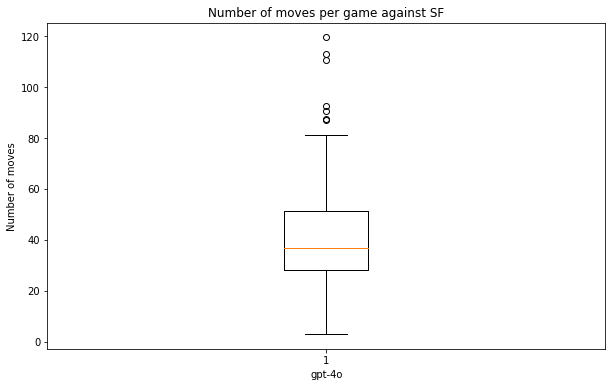

In [22]:
import matplotlib.pyplot as plt

def analyze_games(df_l, model_name):
    # Query for games played by the given model
    model_games = df_l.query(f"(white == '{model_name}' or black == '{model_name}')")
    model_games['nmoves'] = model_games['nmoves'] / 2
    
    # Sum of moves played by the model
    white_nmoves = df_l.query(f"white == '{model_name}'")['nmoves'].sum() / 2
    black_nmoves = df_l.query(f"black == '{model_name}'")['nmoves'].sum() / 2
    t_moves = model_games['nmoves'].sum()

    # Count of illegal moves
    illegal_moves = len(df_l.query(f"(white == '{model_name}' or black == '{model_name}') and has_illegal == True"))
    illegal_moves_10 = len(df_l.query(f"(white == '{model_name}' or black == '{model_name}') and has_illegal == True and illegal_move != '1-0'"))

    # Printing results
    print("illegal moves", round(illegal_moves/t_moves, 5)*100, "%")
    print("illegal_moves without 1-0:", round(illegal_moves_10/t_moves, 5)*100, "%")
    print("Total number of moves played by", model_name, ":", t_moves)
    print("White played", white_nmoves, "moves")
    print("Black played", black_nmoves, "moves")
    print("Number of moves against SF")
    print("The longest game was", model_games['nmoves'].max(), "moves")
    print("The shortest game was", model_games['nmoves'].min(), "moves")
    print("The average game length was", model_games['nmoves'].mean(), "moves")
    print("The median game length was", model_games['nmoves'].median(), "moves")

    # Plotting box plot
    plt.figure(figsize=(10, 6))
    plt.boxplot(model_games['nmoves'])
    plt.title(f"Number of moves per game against SF")
    plt.ylabel("Number of moves")
    plt.xlabel(f"{model_name}")
    plt.savefig(f"{model_name}_games_nmoves.png", dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
# analyze_games(df_non_random, 'gpt-4o')
analyze_games(df_non_random, 'gpt-4o')



202 games played against SF
93 legal games played against SF


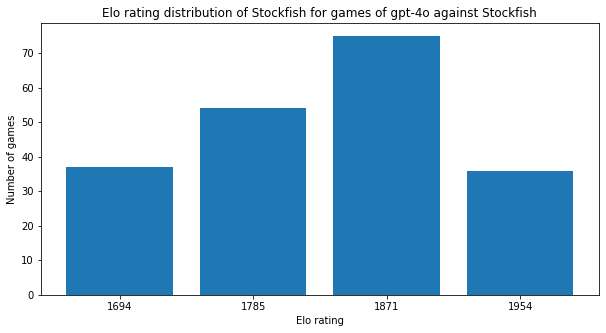

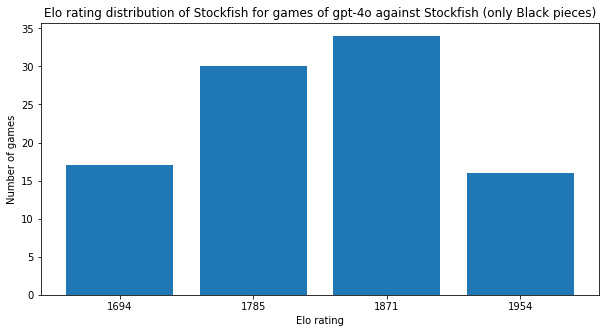

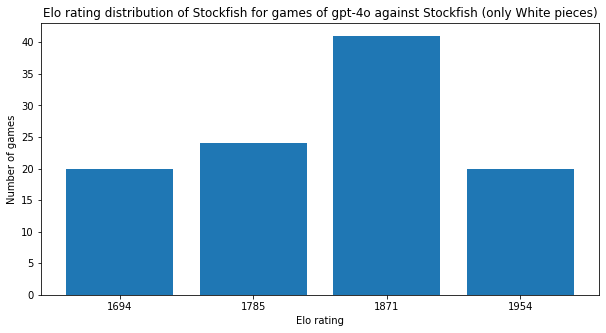

In [23]:
df_gpt4o = df_non_random.query("(white == 'gpt-4o' or black == 'gpt-4o')")
print(len(df_gpt4o), "games played against SF")
print(len(df_gpt4o.query("has_illegal == False")), "legal games played against SF")

# Extracting elo values for games where Stockfish is playing against gpt-4o
stockfish_black_elo_vs_gpt4o_instruct = df_gpt4o['black_elo']
# remove values with '?' value
stockfish_black_elo_vs_gpt4o_instruct = stockfish_black_elo_vs_gpt4o_instruct[stockfish_black_elo_vs_gpt4o_instruct != '?']

stockfish_white_elo_vs_gpt4o_instruct = df_gpt4o['white_elo']
# remove values with '?' value
stockfish_white_elo_vs_gpt4o_instruct = stockfish_white_elo_vs_gpt4o_instruct[stockfish_white_elo_vs_gpt4o_instruct != '?']


# Combining Elo ratings of Stockfish as both white and black player
combined_stockfish_elo = pd.concat([stockfish_white_elo_vs_gpt4o_instruct, stockfish_black_elo_vs_gpt4o_instruct])

import matplotlib.pyplot as plt

# Assuming you have already computed value counts
value_counts = combined_stockfish_elo.value_counts().sort_index()

# Plotting the histogram for combined Elo ratings
plt.figure(figsize=(10,5))
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Elo rating')
plt.ylabel('Number of games')
plt.title('Elo rating distribution of Stockfish for games of gpt-4o against Stockfish')
plt.savefig("stockfish_elo_distribution.png", dpi=300, bbox_inches='tight')
plt.show()


value_counts = stockfish_white_elo_vs_gpt4o_instruct.value_counts().sort_index()

# Plotting the histogram for combined Elo ratings
plt.figure(figsize=(10,5))
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Elo rating')
plt.ylabel('Number of games')
plt.title('Elo rating distribution of Stockfish for games of gpt-4o against Stockfish (only Black pieces)')
plt.savefig("stockfish_elo_distribution_white.png", dpi=300, bbox_inches='tight')
plt.show()

value_counts = stockfish_black_elo_vs_gpt4o_instruct.value_counts().sort_index()

# Plotting the histogram for combined Elo ratings
plt.figure(figsize=(10,5))
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Elo rating')
plt.ylabel('Number of games')
plt.title('Elo rating distribution of Stockfish for games of gpt-4o against Stockfish (only White pieces)')
plt.savefig("stockfish_elo_distribution_black.png", dpi=300, bbox_inches='tight')
plt.show()





In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

def plot_histogram(df):
    # Initialize the matplotlib figure
    plt.figure(figsize=(12, 6))

    # Plot histogram of nmoves
    sns.histplot(df['nmoves'], bins=30, kde=True, color="skyblue")

    # Set plot labels and title
    plt.xlabel('Number of Moves', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Distribution of Number of Moves in Chess Games', fontsize=16)

    # Show the plot
    plt.show()

def plot_boxplot(df):
    # Initialize the matplotlib figure
    plt.figure(figsize=(10, 6))

    # Create a boxplot of nmoves
    sns.boxplot(x=df['nmoves'], color="lightblue")

    # Set plot labels and title
    plt.xlabel('Number of Moves', fontsize=14)
    plt.title('Boxplot of Number of Moves in Chess Games', fontsize=16)

    # Show the plot
    plt.show()

In [25]:
df = df.query("random_engine == False")

In [26]:
df['temperature'].unique()

array([0.])

In [27]:
df.query('nstarting_move <= 2 and temperature == 0.0') # right now nmoves with 1 corresponds to traditional stuff... with 2 corresponds to basic, well-known, random openings and is fair... n > 2 corresponds to k random moves (and is a bit unfair for either side)

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
0,gpt-4o,Stockfish,?,1785,*,174,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Kxe6,games_gpt4o/game439d237f-bef7-4441-af32-f098f0...,,True
1,gpt-4o,Stockfish,?,1785,*,64,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Qxg,games_gpt4o/game3743e16d-bc60-4881-9aec-7d63aa...,,True
2,gpt-4o,Stockfish,?,1785,1-0,89,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/gamec1a003ba-1ebc-4255-b960-f9e44b...,,True
3,gpt-4o,Stockfish,?,1785,*,72,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Rd7,games_gpt4o/gamef811153a-8ef6-4793-9cf6-07dced...,,True
4,gpt-4o,Stockfish,?,1785,*,122,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Re8#,games_gpt4o/game381c16b9-1e68-4f93-88d9-8a43c0...,,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,Stockfish,gpt-4o,1954,?,*,97,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,d1=Q,games_gpt4o/game27ed24bd-f5c7-4cd7-a8af-d7c8db...,,True
223,Stockfish,gpt-4o,1954,?,*,109,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Rxe8,games_gpt4o/game0d54ff62-cd18-47f2-a324-3e233e...,,True
224,Stockfish,gpt-4o,1954,?,*,115,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Rc1,games_gpt4o/gamed9ab2f81-7e7d-4239-a120-139058...,,True
225,Stockfish,gpt-4o,1954,?,*,61,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,True,Rf1+,games_gpt4o/game69404aeb-9fa8-4bf9-996a-c83bf6...,,True


In [28]:
df.query('nstarting_move <= 2 and temperature == 0.8')

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt


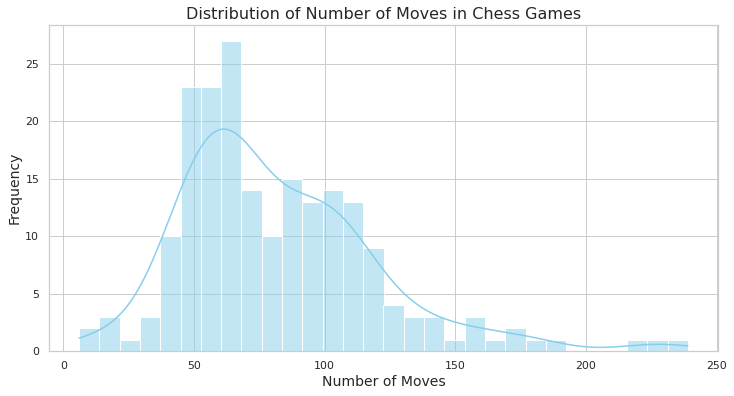

In [29]:


plot_histogram(df)



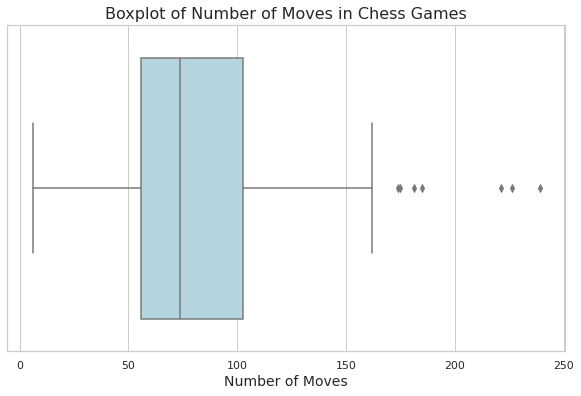

In [30]:


plot_boxplot(df)


In [31]:
def compute_average(df, model_name='gpt-4o'):
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    
    # Convert Elo columns to numeric, setting errors='coerce' to handle non-numeric values
    df_copy['white_elo'] = pd.to_numeric(df_copy['white_elo'], errors='coerce')
    df_copy['black_elo'] = pd.to_numeric(df_copy['black_elo'], errors='coerce')

    # Filter out rows where gpt-4o is the player and get the opponent's Elo
    opponent_elo_white = df_copy[df_copy['white'] == model_name]['black_elo']
    opponent_elo_black = df_copy[df_copy['black'] == model_name]['white_elo']

    # Concatenate the Elo ratings of opponents when gpt-4o played as white and black
    all_opponent_elo = pd.concat([opponent_elo_white, opponent_elo_black])

    # Calculate the average Elo rating of the opponents, excluding missing or NaN values
    average_opponent_elo = all_opponent_elo.mean()

    return average_opponent_elo

compute_average(df, model_name='gpt-4o')


1830.381188118812

In [32]:
from scipy.optimize import fsolve
import numpy as np

def computation_Elo(df,  initial_guess = 1700, model_name='gpt-4o', K=400):
    # Given values
    S_A = compute_score(df, model_name)  # The score of Player A
    R_B = compute_average(df, model_name)  # The rating of Player 

    # Define the equation to solve for R_A
    def equation(R_A, *data):
        S_A, R_B = data
        return S_A - 1 / (1 + 10**((R_B - R_A) / K)) 

    # Solve the equation for R_A
    R_A_solution = fsolve(equation, initial_guess, args=(S_A, R_B))

    # Extract the calculated R_A value
    R_A_calculated = float(R_A_solution[0])
    return R_A_calculated

computation_Elo(df_non_random.query("(white == 'gpt-4o' or black == 'gpt-4o')")), compute_score(df_non_random.query("(white == 'gpt-4o' or black == 'gpt-4o')"), model_name='gpt-4o'), compute_average(df_non_random.query("(white == 'gpt-4o' or black == 'gpt-4o')"), model_name='gpt-4o')

(1587.3991788329445, 0.19801980198019803, 1830.381188118812)

In [33]:

# rs = []
# for i in range(0, 1000):
#     rs.append(compute_elo(df_non_random.query("(white == 'gpt-4o' or black == 'gpt-3.5-turbo-instruct') and `has_illegal` == False").sample(), candidate_name="gpt-3.5-turbo-instruct", starting_elo=1500, K=400))


def lookup_fide_table(score):
        # Data here: https://handbook.fide.com/chapter/B022017
        data = {
            'p': [1.0, .99, .98, .97, .96, .95, .94, .93, .92, .91, .90, .89, .88, .87, .86, .85, .84,
                .83, .82, .81, .80, .79, .78, .77, .76, .75, .74, .73, .72, .71, .70, .69, .68, .67,
                .66, .65, .64, .63, .62, .61, .60, .59, .58, .57, .56, .55, .54, .53, .52, .51, .50,
                .49, .48, .47, .46, .45, .44, .43, .42, .41, .40, .39, .38, .37, .36, .35, .34, .33,
                .32, .31, .30, .29, .28, .27, .26, .25, .24, .23, .22, .21, .20, .19, .18, .17, .16,
                .15, .14, .13, .12, .11, .10, .09, .08, .07, .06, .05, .04, .03, .02, .01],
            'dp': [800, 677, 589, 538, 501, 470, 444, 422, 401, 383, 366, 351, 336, 322, 309, 296, 284,
                273, 262, 251, 240, 230, 220, 211, 202, 193, 184, 175, 166, 158, 149, 141, 133, 125,
                117, 110, 102, 95, 87, 80, 72, 65, 57, 50, 43, 36, 29, 21, 14, 7, 0, -7, -14, -21, 
                -29, -36, -43, -50, -57, -65, -72, -80, -87, -95, -102, -110, -117, -125, -133, -141,
                -149, -158, -166, -175, -184, -193, -202, -211, -220, -230, -240, -251, -262, -273, 
                -284, -296, -309, -322, -336, -351, -366, -383, -401, -444, -470, -501, -538, -589, -677, -800]
        }

        # Convert to DataFrame
        df_fide = pd.DataFrame(data)

        rscore = round(score, 2)

        # lookup score in table
        dp = df_fide.loc[df_fide['p'] == rscore, 'dp'].iloc[0]
        return dp

def fide_elo_computation(dfe, model_name, score=None):
    average_opponents_ratings = compute_average(dfe, model_name)
    if score is None:
        score = compute_score(dfe, model_name)
    dp = lookup_fide_table(score)


    return average_opponents_ratings + dp

                    
def compute_elo(df_l, model_gpt_name):
    df_elo = df_l.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}') and `has_illegal` == False")
    fide_elo_value = round(fide_elo_computation(df_elo, model_gpt_name), 0)
    print(f"{fide_elo_value} Elo for {model_gpt_name} against SF and only with legal games/moves")
    
    df_elo_withillegal = df_l.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}')")
    s, t = compute_score(df_elo_withillegal, model_gpt_name, percentage=False)
    sc = s / len(df_elo_withillegal)
    fide_elo_with_illegal_value = round(fide_elo_computation(df_elo_withillegal, model_gpt_name, sc), 0)
    print(f"{fide_elo_with_illegal_value} Elo for {model_gpt_name} against SF and with all games")

# Usage:
compute_elo(df_non_random, 'gpt-4o')

# print("With temperature=0")
# df_non_random['temperature'] = df_non_random['temperature'].astype(float)
# compute_elo(df_non_random.query("temperature == 0.0"), 'gpt-4o')





1776.0 Elo for gpt-4o against SF and only with legal games/moves
1590.0 Elo for gpt-4o against SF and with all games


In [34]:
df_elo_onlywhite = df_non_random.query("(white == 'gpt-4o') and `has_illegal` == False")
print(round(fide_elo_computation(df_elo_onlywhite, 'gpt-4o'), 0), "Elo for gpt-4o against SF and only with legal games/moves and only with white pieces")

df_elo_onlywhite_withillegal = df_non_random.query("(white == 'gpt-4o')")
mname = 'gpt-4o'
s, t = compute_score(df_elo_onlywhite_withillegal, mname, percentage=False)
sc = s / len(df_elo_onlywhite_withillegal)
print(round(fide_elo_computation(df_elo_onlywhite_withillegal, mname, sc), 0), "Elo for", mname, "against SF and with all games and only with white pieces")

# only black
df_elo_onlyblack_withillegal = df_non_random.query("(black == 'gpt-4o')")
mname = 'gpt-4o'
s, t = compute_score(df_elo_onlyblack_withillegal, mname, percentage=False)
nblack_elo = len(df_elo_onlyblack_withillegal)
if nblack_elo == 0:
    sc = 0
    print("No game, no sense to compute", "Elo for", mname, "against SF and with all games and only with black pieces")
else:
    sc = s / nblack_elo
    print(round(fide_elo_computation(df_elo_onlyblack_withillegal, mname, sc), 0), "Elo for", mname, "against SF and with all games and only with black pieces")

# only black
df_elo_onlyblack = df_non_random.query("(black == 'gpt-4o') and `has_illegal` == False")
if nblack_elo == 0:
    sc = 0
    print("No game, no sense to compute", "Elo for", mname, "against SF and with all games and only with black pieces")
else:
    print(round(fide_elo_computation(df_elo_onlyblack, 'gpt-4o'), 0), "Elo for gpt-4o against SF and only with legal games/moves and only with black pieces")



1801.0 Elo for gpt-4o against SF and only with legal games/moves and only with white pieces
1560.0 Elo for gpt-4o against SF and with all games and only with white pieces
1616.0 Elo for gpt-4o against SF and with all games and only with black pieces
1756.0 Elo for gpt-4o against SF and only with legal games/moves and only with black pieces


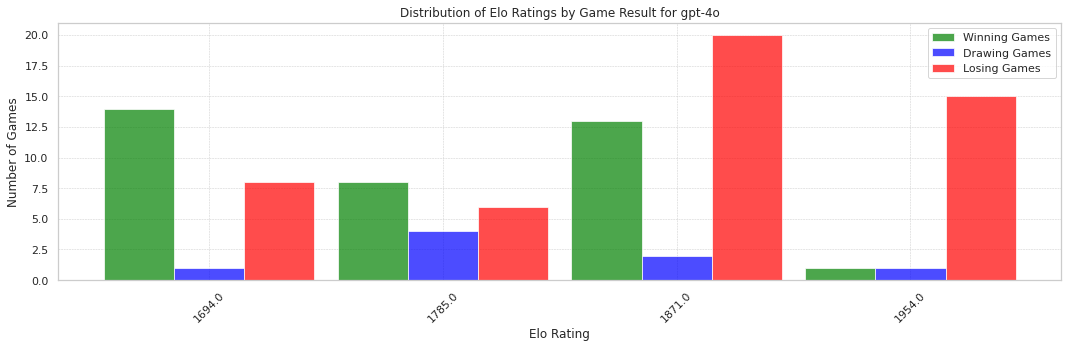

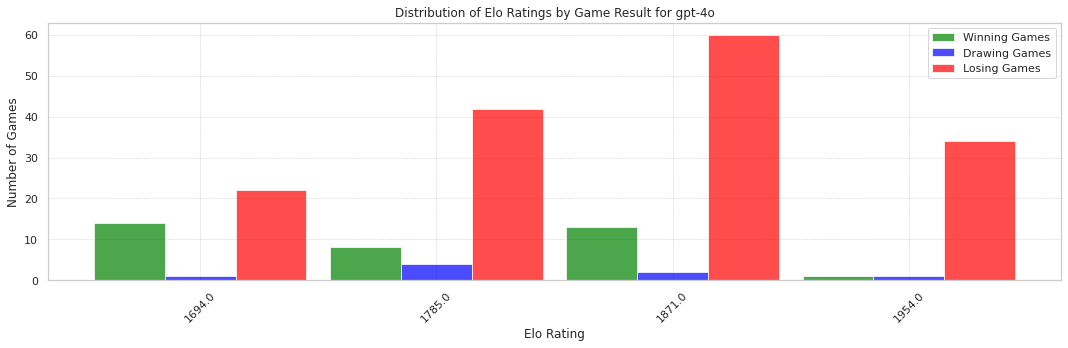

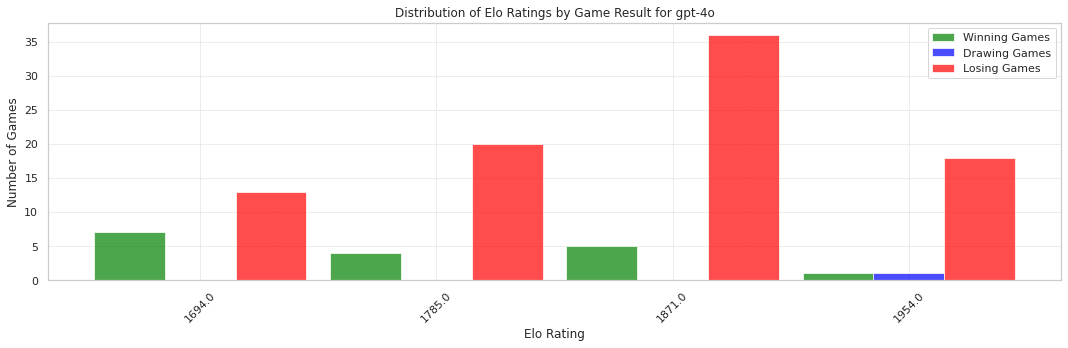

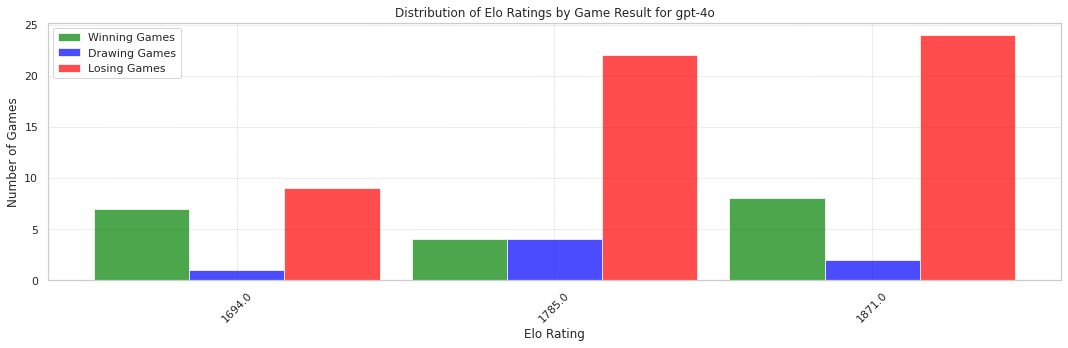

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def extract_elo_ratings(df_l, model_gpt_name, only_legal=True):
    wrs = [] # winning games 
    lrs = [] # losing games
    drs = [] # drawing games
    
    # Filter and iterate over the dataframe
    if only_legal:       
        qur = df_l.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}') and `has_illegal` == False")
    else:
        qur = df_l.query(f"(white == '{model_gpt_name}' or black == '{model_gpt_name}')")
    for _, row in qur.iterrows():
        if row['white'] == model_gpt_name and row['result'] == '1-0':
            wrs.append(row['black_elo'])
        elif row['black'] == model_gpt_name and row['result'] == '0-1':
            wrs.append(row['white_elo'])
        elif row['black'] == model_gpt_name and row['result'] == '1-0':
            lrs.append(row['white_elo'])
        elif row['white'] == model_gpt_name and row['result'] == '0-1':
            lrs.append(row['black_elo'])
        elif row['result'] == '1/2-1/2':
            if row['white'] == model_gpt_name:
                drs.append(row['black_elo'])
            else:
                drs.append(row['white_elo'])
        elif row['result'] == '*': # illegal move!
            if row['white'] == model_gpt_name:
                lrs.append(row['black_elo'])
            elif row['black'] == model_gpt_name:
                lrs.append(row['white_elo'])
        else:
            print("warning")
            print(row)
            continue

    wrs = [float(val) for val in wrs]
    lrs = [float(val) for val in lrs]
    drs = [float(val) for val in drs]
    
    return wrs, lrs, drs

def plot_elo_distribution(wrs, lrs, drs, model_gpt_name):
    # Compute unique Elos and their counts
    unique_elos = sorted(np.unique(wrs))
    win_counts = [wrs.count(elo) for elo in unique_elos]
    draw_counts = [drs.count(elo) for elo in unique_elos]
    lose_counts = [lrs.count(elo) for elo in unique_elos]

    # Plotting
    bar_width = 0.3
    index = np.arange(len(unique_elos))
    plt.figure(figsize=(15, 5))
    plt.bar(index, win_counts, bar_width, alpha=0.7, color='green', label='Winning Games')
    plt.bar(index + bar_width, draw_counts, bar_width, alpha=0.7, color='blue', label='Drawing Games')
    plt.bar(index + 2 * bar_width, lose_counts, bar_width, alpha=0.7, color='red', label='Losing Games')

    plt.xlabel('Elo Rating')
    plt.ylabel('Number of Games')
    plt.title(f'Distribution of Elo Ratings by Game Result for {model_gpt_name}')

    plt.xticks(index + bar_width, unique_elos, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.savefig(f"elo_distribution-scores-{model_gpt_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

def analyze_and_plot_elo_distribution(df_l, model_gpt_name, only_legal=True):
    wrs, lrs, drs = extract_elo_ratings(df_l, model_gpt_name, only_legal=only_legal)
    plot_elo_distribution(wrs, lrs, drs, model_gpt_name)



# Return the functions for further use
analyze_and_plot_elo_distribution(df_non_random, "gpt-4o", only_legal=True)
analyze_and_plot_elo_distribution(df_non_random, "gpt-4o", only_legal=False)


analyze_and_plot_elo_distribution(df_non_random.query("white == 'gpt-4o'"), "gpt-4o", only_legal=False)
analyze_and_plot_elo_distribution(df_non_random.query("black == 'gpt-4o'"), "gpt-4o", only_legal=False)
# df_non_random








In [36]:
final_elo = fide_elo_computation(df.query('nstarting_move <= 2 and temperature == 0.0'), 'gpt-4o') # starting_elo=1700, K=40)
print(f"Final Elo of gpt-4o: {final_elo}") # FIXME



Final Elo of gpt-4o: 1590.381188118812


In [37]:
for k, v in df_non_random.query("(white == 'gpt-4o' or black == 'gpt-4o') and `has_illegal` == False").iterrows():
    if v['white'] == "gpt-4o" and v['black_elo'] != '?':
            opponent_elo = float(v['black_elo'])
    elif v['black'] == "gpt-4o" and v['white_elo'] != '?':
        opponent_elo = float(v['white_elo'])
    else:
        print("warning: no elo found for opponent", k, v['folder_name'])
        continue
    result = v['result']
    if result == '*':
        print("warning: no result found for opponent", k, v['folder_name'])
        continue

In [38]:
len(df.query('nstarting_move > 2'))

0

In [39]:
df.query('nstarting_move > 2')

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt


In [40]:
df['has_illegal'].unique()

array([True, False], dtype=object)

In [41]:
df['illegal_move'].value_counts()

         93
Rxe8      3
Qxb8      2
exf7+     2
Rc1       2
         ..
Bd2       1
Nxc6      1
Rd7       1
Qxd7+     1
Rxf5      1
Name: illegal_move, Length: 99, dtype: int64

In [42]:
df['base_pgn_prompt'].value_counts()

True    202
Name: base_pgn_prompt, dtype: int64

In [43]:
computation_Elo(df.query('base_pgn_prompt == False'))

/home/mathieuacher/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


1700.0

In [44]:
df.query("(white == 'gpt-4' or black == 'gpt-4')")

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt


In [45]:
df.query("(white == 'gpt-3.5-turbo' or black == 'gpt-3.5-turbo')")

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt


In [46]:
df_non_random.query("(white == 'gpt-4o' or black == 'gpt-4o')").query("result != '*'").sort_values(by="nmoves", ascending=True)

,white,black,white_elo,black_elo,result,nmoves,nstarting_move,pgn_base,temperature,random_engine,has_illegal,illegal_move,folder_name,pgn_base_moves,base_pgn_prompt
125,Stockfish,gpt-4o,1871,?,1-0,39,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/gameb74abc1b-68c8-4195-86e6-c4e281...,,True
216,Stockfish,gpt-4o,1954,?,1-0,41,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/game9fa84241-0aa4-4b5a-983b-649130...,,True
130,Stockfish,gpt-4o,1785,?,1-0,43,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/gamed6b31cc9-0ca4-4bdf-9c9e-b28ef0...,,True
209,Stockfish,gpt-4o,1954,?,1-0,43,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/gamead79924b-c371-478e-a7fb-c7fb79...,,True
210,Stockfish,gpt-4o,1954,?,1-0,45,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/game65d1539c-3b7e-4efc-82ad-68cd85...,,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,Stockfish,gpt-4o,1785,?,1/2-1/2,162,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/gameb0cbdbef-3364-4aa6-9105-128638...,,True
121,Stockfish,gpt-4o,1871,?,1/2-1/2,175,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/gamef6f3d36a-3965-4d7e-abc0-9eb6f7...,,True
153,Stockfish,gpt-4o,1785,?,1/2-1/2,181,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/game5c3ae89a-82b0-4fb6-9b0a-3ce3eb...,,True
133,Stockfish,gpt-4o,1785,?,1-0,221,1,"[Event ""FIDE World Championship Match 2024""]\n...",0.0,False,False,,games_gpt4o/gamedfa2dea5-d7a0-43c9-9ed6-7d97f2...,,True
